In [1]:
# author: Zhuocheng Sun, Yueyu Wang
# instructor: Tyler Caraza-Harter

from shapely.geometry import Point, Polygon
import shapefile as shp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("apartments.csv")
pts_col = []

df = df[df["PropertyClass"] == "Residential"]

for pt in df[["XCoord", "YCoord"]].itertuples():
    pts_col.append(Point(pt.XCoord, pt.YCoord))
df["geometry"] = pts_col
df = df[["Address", "PropertyUse", "Bedrooms", "geometry", "XCoord", "YCoord"]]

df["Bedrooms"] = df["Bedrooms"]  + 0.01 # add a small value to handle 0 bedroom cases.
df = gpd.GeoDataFrame(df)
df = df.set_crs("esri:103412")
df = df.to_crs(epsg=4326)

df = df[["Address", "PropertyUse", "Bedrooms", "geometry", "XCoord", "YCoord"]]

df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (42,43,104,109,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Address  PropertyUse  Bedrooms                    geometry  \
0  2333 Carling Dr Unit 4  Condominium      2.01  POINT (-89.46093 43.02791)   
1  2337 Carling Dr Unit 1  Condominium      2.01  POINT (-89.46093 43.02791)   
2  2337 Carling Dr Unit 2  Condominium      2.01  POINT (-89.46093 43.02791)   
3  2337 Carling Dr Unit 3  Condominium      2.01  POINT (-89.46093 43.02791)   
4  2337 Carling Dr Unit 4  Condominium      2.01  POINT (-89.46093 43.02791)   

          XCoord         YCoord  
0  800650.916687  465776.525813  
1  800650.916687  465776.525813  
2  800650.916687  465776.525813  
3  800650.916687  465776.525813  
4  800650.916687  465776.525813

### Generally, 18 year-olds could be either 12th-grade students or college freshmen. Since we found many data entries with majorities of 18-19 year-olds, and many of those properties are located near UW campus, we think it makes more sense to regard them as college students rather than 12th-grade students. Thus, for simplicity, we only count 5 to 17 year-olds as K-12 student in this notebook.

In [3]:
census_df = pd.read_csv("census_by_block_2010/sex_age.csv")
census_df["GEO_ID"] = census_df["GEO_ID"]
census_df = census_df[["GEO_ID", "NAME", "P012001", "P012004", "P012005", "P012006", "P012028", "P012029", "P012030"]]
census_df = census_df.rename(columns = {"NAME":"Area", "P012001": "Total_people", "P012004": "5-9yrMale", "P012005": "10-14yrMale", "P012006": "15-17yrMale", "P012028": "5-9yrFemale", "P012029": "10-14yrFemale", "P012030": "15-17yrFemale"}, inplace=False)
census_df = census_df[1:]
census_df["Total_people"] = census_df["Total_people"].astype(int)
census_df["5-9yr"] = census_df["5-9yrMale"].astype(int) + census_df["5-9yrFemale"].astype(int)
census_df["10-14yr"] = census_df["10-14yrMale"].astype(int) + census_df["10-14yrFemale"].astype(int)
census_df["15-17yr"] = census_df["15-17yrMale"].astype(int) + census_df["15-17yrFemale"].astype(int)

census_df["Total_K-12_block"] = census_df["5-9yr"] + census_df["10-14yr"] + census_df["15-17yr"]
census_df = census_df[census_df["Total_K-12_block"] != 0]
census_df.head()

GEO_ID  \
1  1000000US550250001001000   
2  1000000US550250001001001   
4  1000000US550250001001003   
5  1000000US550250001001004   
7  1000000US550250001001006   

                                                Area  Total_people 5-9yrMale  \
1  Block 1000, Block Group 1, Census Tract 1, Dan...           170         1   
2  Block 1001, Block Group 1, Census Tract 1, Dan...            23         1   
4  Block 1003, Block Group 1, Census Tract 1, Dan...            38         1   
5  Block 1004, Block Group 1, Census Tract 1, Dan...           141         4   
7  Block 1006, Block Group 1, Census Tract 1, Dan...            38         1   

  10-14yrMale 15-17yrMale 5-9yrFemale 10-14yrFemale 15-17yrFemale  5-9yr  \
1           3           1           1             7             4      2   
2           0           2           0             0             1      1   
4           1           0           0             1             3      1   
5           7           4           6             4             3     10   
7           0           3           0             6             0      1   

   10-14yr  15-17yr  Total_K-12_block  
1       10        5                17  
2        0        3                 4  
4        2        3                 6  
5       11        7                28  
7        6        3                10

In [4]:
# spatial join - take dataset A + dataset B = dataset AB, based on space/geographic relationship
# two datasets must have a matched CRS: coordinate reference system

dane = gpd.read_file("dane/dane.shp")
dane["GEO_ID"] = "1000000US" + dane["GEOID20"]
dane.head()

STATEFP20 COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20      NAME20  \
0        55        025    002900      2006  550250029002006  Block 2006   
1        55        025    012700      1050  550250127001050  Block 1050   
2        55        025    011404      4001  550250114044001  Block 4001   
3        55        025    000504      3015  550250005043015  Block 3015   
4        55        025    001200      4020  550250012004020  Block 4020   

  MTFCC20  UR20 UACE20 UATYPE20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20  \
0   G5040  None   None     None          S    38858         0  +43.0614916   
1   G5040  None   None     None          S  1055458         0  +43.0221242   
2   G5040  None   None     None          S    47453         0  +43.1937131   
3   G5040  None   None     None          S     8739         0  +43.0307340   
4   G5040  None   None     None          S     7686         0  +43.0644947   

     INTPTLON20                                           geometry  \
0  -089.3182030  POLYGON ((-89.31992 43.06209, -89.31823 43.062...   
1  -089.8262570  POLYGON ((-89.83427 43.02107, -89.83427 43.021...   
2  -089.2948433  POLYGON ((-89.29664 43.19458, -89.29664 43.194...   
3  -089.5300742  POLYGON ((-89.53060 43.03119, -89.52971 43.031...   
4  -089.4064235  POLYGON ((-89.40721 43.06476, -89.40698 43.064...   

                     GEO_ID  
0  1000000US550250029002006  
1  1000000US550250127001050  
2  1000000US550250114044001  
3  1000000US550250005043015  
4  1000000US550250012004020

In [5]:
dane.to_crs(df.crs, inplace=True)
dane['area'] = dane.to_crs(epsg=3857).area/2.59e+06
block_with_apartment = gpd.sjoin(df, dane, how="left", op="within")
block_with_apartment = block_with_apartment[['Address', 'PropertyUse','Bedrooms','geometry', "XCoord", "YCoord",  'GEO_ID', 'area']]
block_with_apartment.head()

Address  PropertyUse  Bedrooms                    geometry  \
0  2333 Carling Dr Unit 4  Condominium      2.01  POINT (-89.46093 43.02791)   
1  2337 Carling Dr Unit 1  Condominium      2.01  POINT (-89.46093 43.02791)   
2  2337 Carling Dr Unit 2  Condominium      2.01  POINT (-89.46093 43.02791)   
3  2337 Carling Dr Unit 3  Condominium      2.01  POINT (-89.46093 43.02791)   
4  2337 Carling Dr Unit 4  Condominium      2.01  POINT (-89.46093 43.02791)   

          XCoord         YCoord                    GEO_ID     area  
0  800650.916687  465776.525813  1000000US550250006002003  0.04846  
1  800650.916687  465776.525813  1000000US550250006002003  0.04846  
2  800650.916687  465776.525813  1000000US550250006002003  0.04846  
3  800650.916687  465776.525813  1000000US550250006002003  0.04846  
4  800650.916687  465776.525813  1000000US550250006002003  0.04846

#### We now have census data for each block in Madison. To estimate the number of K-12 students in each property, we think using the formula: K-12_est = (number of bedrooms in a property) * (number of K-12 students in the block)/ (number of bedrooms in the block) is a good approach for now.

In [6]:
merged = pd.merge(block_with_apartment, census_df, on="GEO_ID")
merged = merged[["Area","Address", "PropertyUse", "Bedrooms", "geometry", "XCoord", "YCoord", "Total_people", "Total_K-12_block", "GEO_ID", "area"]]
merged['BlockBedrooms'] = merged.groupby(['GEO_ID']).Bedrooms.transform('sum')

In [7]:
merged["K12_est"] = merged["Total_K-12_block"] * merged["Bedrooms"] / merged["BlockBedrooms"]
K12_df = merged

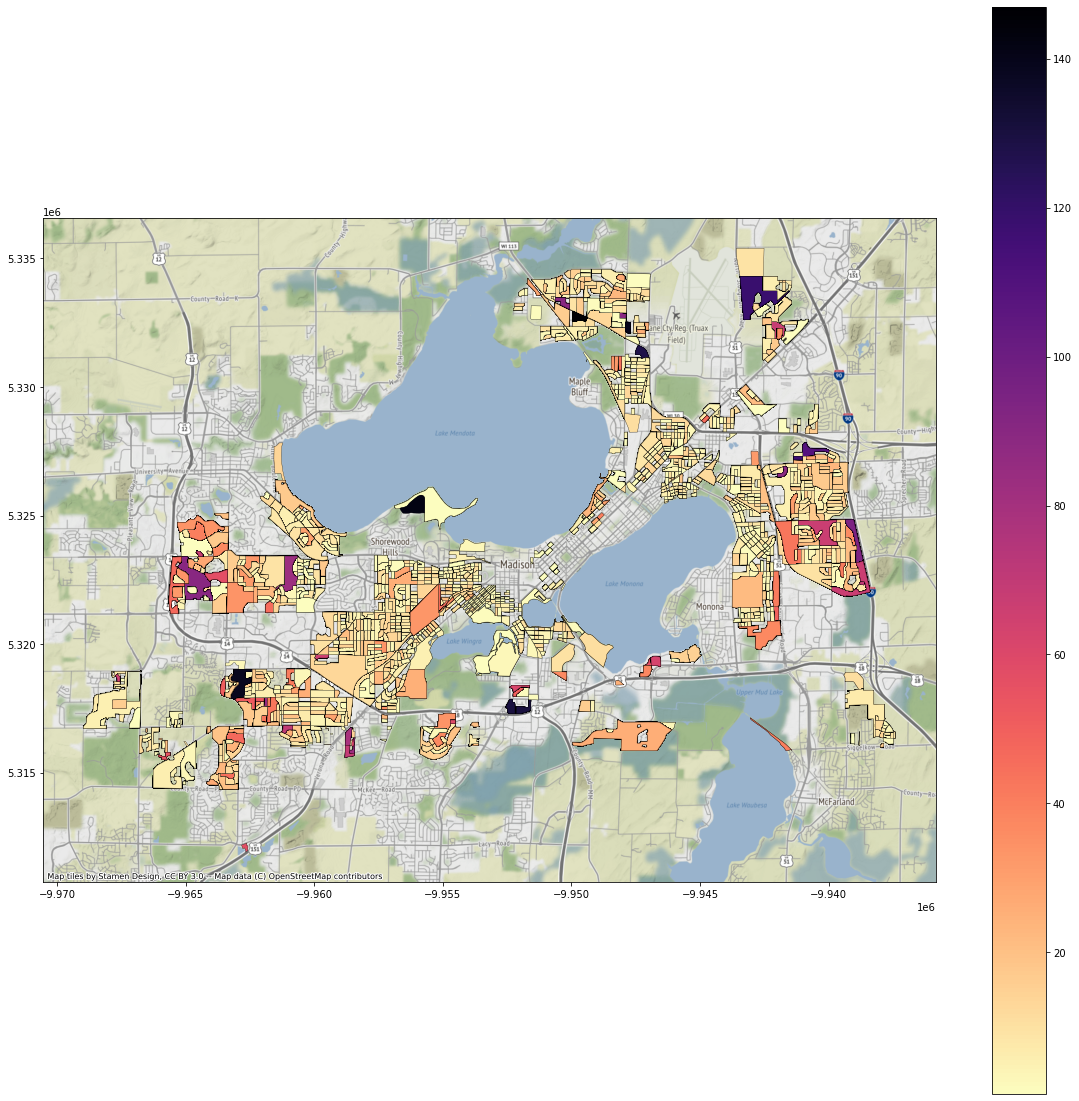

In [8]:
madison = gpd.sjoin(K12_df, dane, how="right", op="within")
madison = madison[madison["Total_K-12_block"] >= 0]
madison = madison.to_crs(epsg=3857)
ax = madison.plot(figsize=(20,20), edgecolor='black', linewidth=0.3, column='Total_K-12_block', cmap='magma_r', k=50, legend=True)
ctx.add_basemap(ax)

## Linear Regression part

In [9]:
Condominium_bedroom_block = merged[(merged["PropertyUse"] == "Condominium") | (merged["PropertyUse"] == "2 unit Apartment")
                                   | (merged["PropertyUse"] == "3 unit Apartment") | (merged["PropertyUse"] == "4 unit Apartment")
                                   | (merged["PropertyUse"] == "5 unit Apartment") | (merged["PropertyUse"] == "6 unit Apartment")
                                   | (merged["PropertyUse"] == "7 unit Apartment")]
Condominium_bedroom_block = Condominium_bedroom_block[["Area", "Address", "PropertyUse", "Bedrooms", "Total_K-12_block", "GEO_ID", "BlockBedrooms", "geometry", "area"]]
Condominium_bedroom_block["Apartment_bedroom"] = Condominium_bedroom_block.groupby(['GEO_ID']).Bedrooms.transform('sum')
Condominium_bedroom_block["other_bedroom"] = Condominium_bedroom_block["BlockBedrooms"] - Condominium_bedroom_block["Apartment_bedroom"]
Condominium_bedroom_block = Condominium_bedroom_block.drop_duplicates("GEO_ID")
Condominium_bedroom_block = Condominium_bedroom_block[["GEO_ID", "Apartment_bedroom", "other_bedroom"]]
total_bedroom_block = merged[["GEO_ID", "BlockBedrooms", "Total_K-12_block", "geometry", "area"]]
total_bedroom_block = total_bedroom_block.drop_duplicates("GEO_ID")
result = total_bedroom_block.merge(Condominium_bedroom_block, on="GEO_ID", how = "outer")
result["Apartment_bedroom"].fillna(0, inplace=True)
result["other_bedroom"].fillna(result["BlockBedrooms"], inplace=True)
result

GEO_ID  BlockBedrooms  Total_K-12_block  \
0     1000000US550250006002003         141.73                79   
1     1000000US550250005012004           3.01                 2   
2     1000000US550250006003021           9.04                 2   
3     1000000US550250006002007          27.17                83   
4     1000000US550250014022008         116.30                37   
...                        ...            ...               ...   
1377  1000000US550250006002001          12.01                14   
1378  1000000US550250004072012           0.01                70   
1379  1000000US550250002052009          88.45                 7   
1380  1000000US550250109031015         213.83                 7   
1381  1000000US550250111013002           0.01                14   

                        geometry      area  Apartment_bedroom  other_bedroom  
0     POINT (-89.46093 43.02791)  0.048460             141.72           0.01  
1     POINT (-89.46611 43.02981)  0.001369               0.00           3.01  
2     POINT (-89.44750 43.02810)  0.003821               0.00           9.04  
3     POINT (-89.45832 43.02627)  0.017482               0.00          27.17  
4     POINT (-89.42949 43.02727)  0.058471               0.00         116.30  
...                          ...       ...                ...            ...  
1377  POINT (-89.45869 43.02920)  0.016106              12.01           0.00  
1378  POINT (-89.50338 43.04400)  0.002009               0.00           0.01  
1379  POINT (-89.50895 43.07613)  0.007161              88.45           0.00  
1380  POINT (-89.53991 43.04147)  0.004795             213.83           0.00  
1381  POINT (-89.48268 43.09456)  0.139753               0.00           0.01  

[1382 rows x 7 columns]

Text(0.5, 1.0, 'Linear Regression Coefficients')

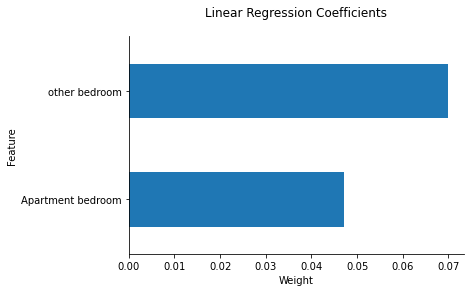

In [10]:
xcol = ["Apartment_bedroom", "other_bedroom"]
model1 = Pipeline([
            ("lr", LinearRegression())
        ])
model1.fit(result[xcol], result["Total_K-12_block"])

idx = [t.replace("_", " ") for t in xcol]
ax3 = pd.Series(model1["lr"].coef_, index=idx).plot.barh()
ax3.set_xlabel("Weight")
ax3.set_ylabel("Feature")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.set_title("Linear Regression Coefficients", pad=20)

## Top 20 apartments table

In [11]:
# sort by the number of K-12 children estimation grouped by Point.
K12_df["K-12_by_point"] = K12_df.groupby(by=["XCoord", "YCoord"])["K12_est"].transform('sum')
point_order = K12_df.sort_values(by=['K-12_by_point'], ascending=False)

In [12]:
Top_20 = K12_df
Top_20 = Top_20[(Top_20["PropertyUse"] == "Condominium") | (Top_20["PropertyUse"] == "2 unit Apartment")
                                   | (Top_20["PropertyUse"] == "3 unit Apartment") | (Top_20["PropertyUse"] == "4 unit Apartment")
                                   | (Top_20["PropertyUse"] == "5 unit Apartment") | (Top_20["PropertyUse"] == "6 unit Apartment")
                                   | (Top_20["PropertyUse"] == "7 unit Apartment")]
Top_20["Apartment_bedrooms"] = Top_20.groupby(["XCoord", "YCoord"]).Bedrooms.transform(sum)
Top_20 = Top_20.drop_duplicates("geometry")
Top_20 = Top_20.sort_values(by=['K-12_by_point'], ascending=False)
Top_20 = Top_20[:20]
Top_20 = Top_20[["Area", "Address", "geometry", "Apartment_bedrooms", "K-12_by_point"]]
Top_20.to_csv("Top20_Apartments.csv", index = False)

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


## Plots

#### cumulative children live in apartments

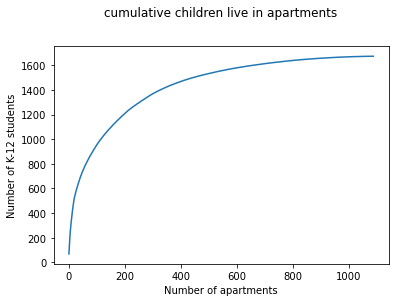

In [13]:
Buildings = K12_df[["GEO_ID", "PropertyUse", "geometry", "Area", "K-12_by_point"]]
Buildings = Buildings[(Buildings["PropertyUse"] == "Condominium") | (Buildings["PropertyUse"] == "2 unit Apartment")
                                   | (Buildings["PropertyUse"] == "3 unit Apartment") | (Buildings["PropertyUse"] == "4 unit Apartment")
                                   | (Buildings["PropertyUse"] == "5 unit Apartment") | (Buildings["PropertyUse"] == "6 unit Apartment")
                                   | (Buildings["PropertyUse"] == "7 unit Apartment")]
Buildings = Buildings.drop_duplicates("geometry")
Buildings = Buildings.sort_values(by=['K-12_by_point'], ascending=False)
K12_data = np.array(Buildings["K-12_by_point"].tolist())
plt.plot(K12_data.cumsum())
plt.axis('tight')
plt.title("cumulative children live in apartments", pad=30)
plt.xlabel("Number of apartments")
plt.ylabel("Number of K-12 students")
plt.show()

## Use the linear regression coef to improve the estimate


In [14]:
total = model1["lr"].coef_[0] + model1["lr"].coef_[1]
apt_pro = model1["lr"].coef_[0]
house_pro = model1["lr"].coef_[1]

result["K12_in_apt"] = result["Total_K-12_block"] / (result["other_bedroom"] + result["Apartment_bedroom"] * (apt_pro/house_pro)) * (result["Apartment_bedroom"] * (apt_pro/house_pro))
result["K12_in_other"] = result["Total_K-12_block"] - result["K12_in_apt"]
result['apt_density'] = result['K12_in_apt'] / result['area']
result['other_density'] = result['K12_in_other'] / result['area']
result.head()

GEO_ID  BlockBedrooms  Total_K-12_block  \
0  1000000US550250006002003         141.73                79   
1  1000000US550250005012004           3.01                 2   
2  1000000US550250006003021           9.04                 2   
3  1000000US550250006002007          27.17                83   
4  1000000US550250014022008         116.30                37   

                     geometry      area  Apartment_bedroom  other_bedroom  \
0  POINT (-89.46093 43.02791)  0.048460             141.72           0.01   
1  POINT (-89.46611 43.02981)  0.001369               0.00           3.01   
2  POINT (-89.44750 43.02810)  0.003821               0.00           9.04   
3  POINT (-89.45832 43.02627)  0.017482               0.00          27.17   
4  POINT (-89.42949 43.02727)  0.058471               0.00         116.30   

   K12_in_apt  K12_in_other  apt_density  other_density  
0   78.991733      0.008267  1630.045071       0.170589  
1    0.000000      2.000000     0.000000    1460.783809  
2    0.000000      2.000000     0.000000     523.439331  
3    0.000000     83.000000     0.000000    4747.812087  
4    0.000000     37.000000     0.000000     632.786986

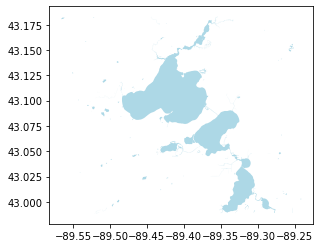

In [15]:
lake_df = gpd.read_file("lakes.zip")
lake_df.plot(color="lightblue")

### The density plot of k12 in apartment

In [16]:
result = gpd.GeoDataFrame(result)
lake_df = lake_df.to_crs(result.crs)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
ax = apartment_madison.plot(figsize=(20,20), column='apt_density', cmap='magma_r', k=50, legend=True)
lake_df.plot(ax=ax,color="lightblue")

### The density plot of k12 in other house

In [17]:
result = gpd.GeoDataFrame(result)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
ax = apartment_madison.plot(figsize=(20,20), column='other_density', cmap='magma_r', k=50, legend=True)
lake_df.plot(ax=ax,color="lightblue")

## Properties That May Have K-12 Kids (by estimation)

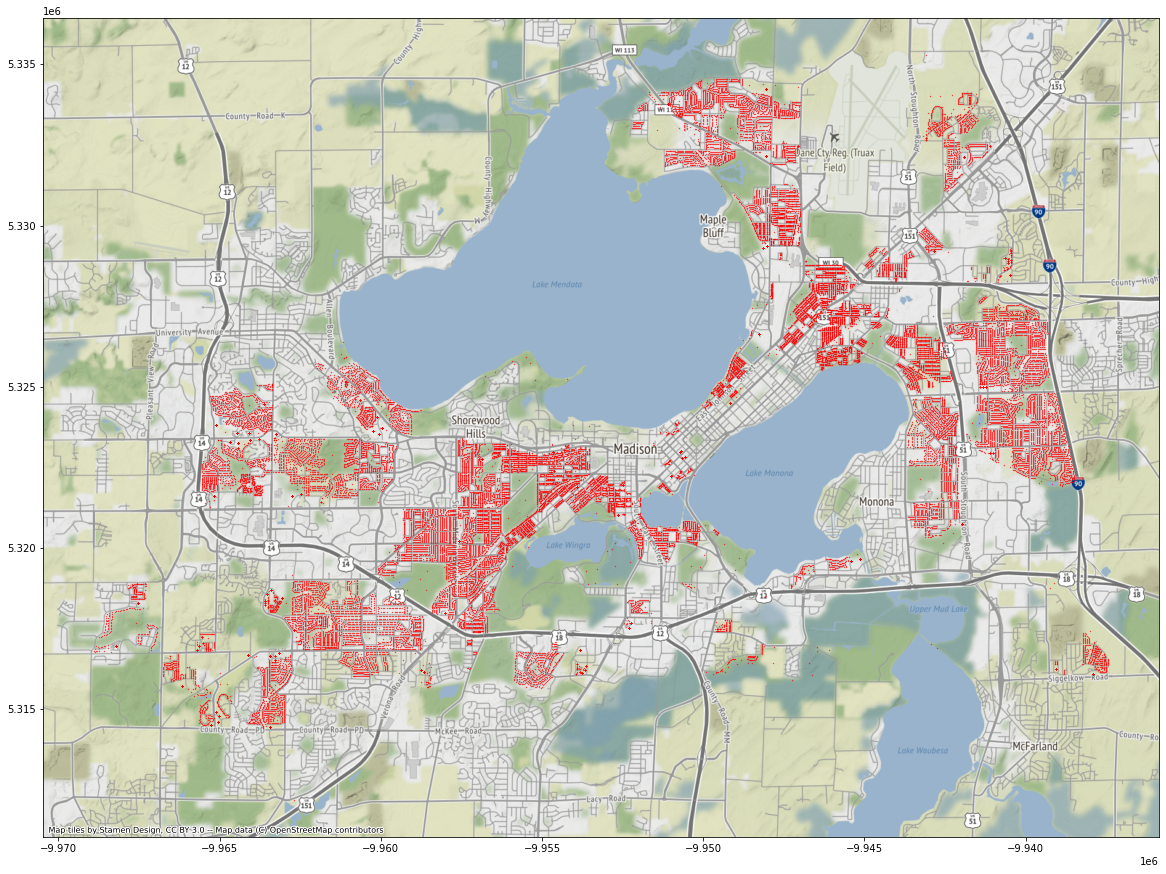

In [18]:
K12_df = K12_df.to_crs(epsg=3857)
ax_k12 = K12_df.plot(markersize=0.1, figsize=(20,20), color="red")
ax2 = ctx.add_basemap(ax_k12)

## Makersize Represented by the Number of K-12 Kids (by estimation)

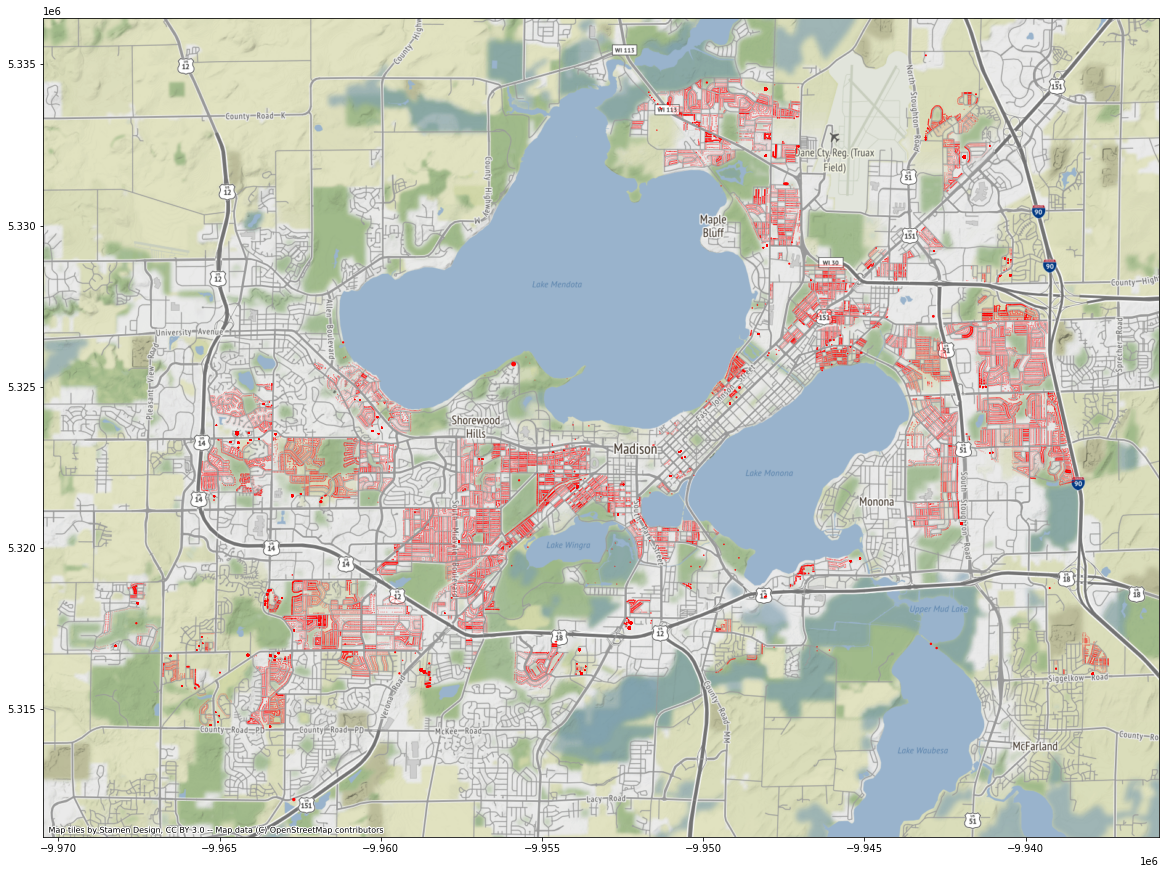

In [19]:
ax_k12_with_size = K12_df.plot(markersize=K12_df["K-12_by_point"]/10, figsize=(20,20), color="red")
ax3 = ctx.add_basemap(ax_k12_with_size)

## All Residential Properties in City of Madison

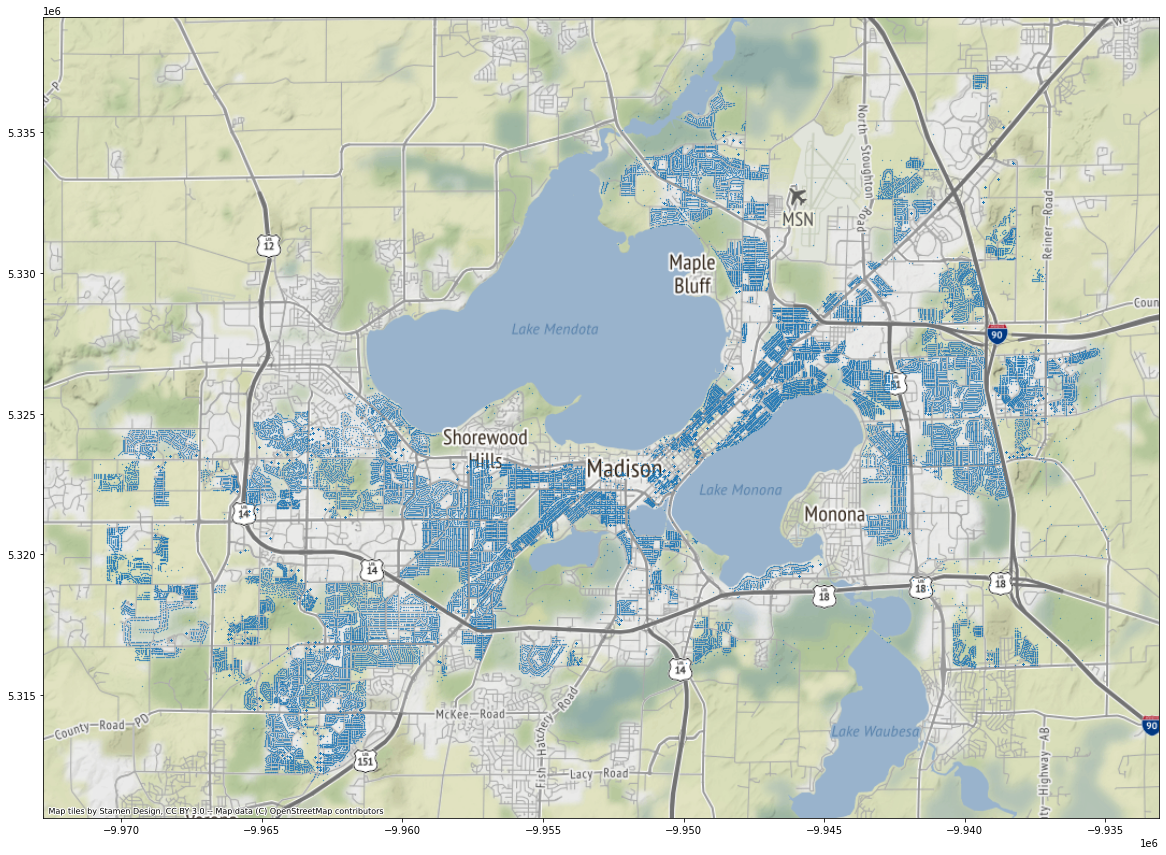

In [20]:
df = df.to_crs(epsg=3857)
ax = df.plot(markersize=0.1, figsize=(20,20))

ctx.add_basemap(ax)